# Ejercicio 12

Reproduzca el panel derecho la Figura 2.9 de ISLR (solamente las curvas de test y training) utilizando los datos de fitting.txt y métodos MCMC para encontrar los mejor parámetros de los modelos polinomiales de grado cero hasta diez.

In [2]:
from IPython.display import Image
#Image("Imagen29.png",width=500, height=500,align="center")


<img src="./Imagen29.png" width="500" height="500" align="center"/>

Con el fin de evaluar el desempeño del metodo estadistico de aprendizaje para una serie de datos dados, es necesario medir que tan bien sus predicciones coinciden con los datos observados. De esta forma es necesario cuantificar que tan cerca está un valor de una predicción con un valor de un dato observado.

Fijada una regresión, lo más común es evaluar sus distancias medias cuadradas (MSE), las cuales están dadas por:

$$MSE=\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\hat{f}(x_i))^2 $$

En donde $\hat{f}(x_i)$ es la predicción que $\hat{f}$ da para la i-ésima observación. El valor de MSE será pequeño si las respuestas predichas están muy cercanas a los datos observados, de lo contrario esto puede crecer de forma arbitraria.


In [3]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [4]:
def model(x_datos,param):
    y=x_datos.copy()
    y[:]=0
    for i in range(len(param)):
        y += param[i]*x_datos**(i)
    return y
def logprior(param):
    for i in range(len(param)):
        if np.abs(param[i])<1:
            p = 0.0
        else:        
            p = -np.inf
    return p
def loglikelihood(x_obs, y_obs, sigma_y_obs, param):
    d = y_obs -  model(x_obs,param)
    d = d/sigma_y_obs
    d = -0.5 * d**2
    norm = 2.0*np.pi*sigma_y_obs**2
    return np.sum(d-(len(x_obs)/2.0)*np.log(norm))

In [5]:
def Monte_carlo_Hastings(x_obs, y_obs, sigma_y_obs, N,Order):
    l_param =[np.random.uniform(-1,1,size=Order)]
    sigma_param = np.random.uniform(0,1,size=Order)
    n_param = len(sigma_param)
    logposterior = np.zeros(N)
    for i in range(1,N):
        propuesta  = l_param[i-1] + np.random.normal(size=n_param)*sigma_param
        logposterior_viejo = loglikelihood(x_obs, y_obs, sigma_y_obs, l_param[i-1]) + logprior(l_param[i-1])
        logposterior_nuevo = loglikelihood(x_obs, y_obs,sigma_y_obs, propuesta) + logprior(propuesta)

        r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
        alpha = np.random.random()
        if(alpha<r):
            l_param.append(propuesta)
            logposterior[i]= logposterior_nuevo
        else:
            l_param.append(l_param[i-1])
            logposterior[i] = logposterior_viejo
    l_param=np.array(l_param)
    l_param = l_param[N//10:,:]
    return l_param

In [6]:
data = pd.read_csv("fitting.txt",sep=" ")
X=np.array(data["x"])
Y=np.array(data["y"])
sigma=np.array(data["sigma_y"])

In [7]:
N=50000
x_obs = X
y_obs = Y
sigma_y = sigma
Orden_max = 10
escogencia = np.random.choice(len(x_obs),replace=False, size = len(data))
# se escoje aleatoriamente los indices de los datos

In [26]:
X_train=[]
Y_train=[]
sigma_train=[]
for i in escogencia[:int(len(data)/2)]: # se toman los primero diez
    X_train.append(x_obs[i])
    Y_train.append(y_obs[i])
    sigma_train.append(sigma_y[i])

X_train=np.array(X_train)
Y_train=np.array(Y_train)
sigma_train=np.array(sigma_train)

In [27]:
param = [np.zeros(Orden_max)] # esto se usa para que todos los arreglos queden del mismo tamaño
for i in range(Orden_max):
    param.append(Monte_carlo_Hastings(X_train, Y_train, sigma_train, N,i+1))

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


In [28]:
param.pop(0) # se elimina el primer elemento
Parametros=np.zeros((Orden_max,Orden_max))

In [29]:
for i in range(Orden_max):
    new_param=np.array(param[i])
    for j in range(len(new_param[i])):
       Parametros[i,j]=new_param[i,j]

In [30]:
# se calcula el error para el conunto de datos de entrenamiento     
R_sq_1=np.zeros(Orden_max)
for i in range(Orden_max):
    Y_teorico =model(X_train,Parametros[i])
    R2 =np.sum((Y_train-Y_teorico)**2/sigma_train**2)
    R2 = R2/10
    R_sq_1[i]=R2

In [41]:
def MSE(Y_pred,Y_datos,sigma):
    mse=np.sum((Y_pred-Y_datos)**2/sigma**2)
    mse=mse/len(Y_pred)
    return mse
    

In [42]:
R_sq_1=np.zeros(Orden_max)
for i in range(Orden_max):
    Y_teorico =model(X_train,Parametros[i])
    R_sq_1[i]=MSE(Y_teorico,Y_train,sigma_train)


In [43]:
Xobs=[]
Yobs=[]
sigmaobs=[]
for i in escogencia[10:]:
    Xobs.append(x_obs[i])
    Yobs.append(y_obs[i])
    sigmaobs.append(sigma_y[i])
Xobs=np.array(Xobs)
Yobs=np.array(Yobs)
sigmaobs=np.array(sigmaobs)

In [44]:

# se calcula ahora el error para el nuevo conjunto de datos
R_sq_2=np.zeros(Orden_max)
for i in range(Orden_max):
    Y_teorico =model(Xobs,Parametros[i])
    R2 =np.sum((Yobs-Y_teorico)**2/sigmaobs**2)
    R2 = R2/10
    R_sq_2[i]=R2


In [46]:
R_sq_2=np.zeros(Orden_max)
for i in range(Orden_max):
    Y_teorico =model(Xobs,Parametros[i])
    R_sq_2[i]=MSE(Y_teorico,Yobs,sigmaobs)

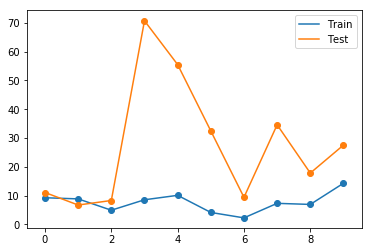

In [47]:
Grados=np.arange(0,Orden_max)
plt.scatter(Grados,R_sq_1)
plt.scatter(Grados,R_sq_2)
plt.plot(Grados,R_sq_1,label="Train")
plt.plot(Grados,R_sq_2,label="Test")
plt.savefig("R2_grados.pdf")
plt.legend()
plt.show()